## Задача 1

Функция вероятности Бернулли
$$f(k;p)=p^{k}(1-p)^{1-k}$$ $$k\in(0,1)$$

Правдоподобие наблюдений
$$\prod_{k=0}^{M} p^{k}(1-p)^{1-k}$$

Логарифм правдоподобия
$$\log\prod_{k=0}^{M} p^{k}(1-p)^{1-k}==\sum_{k=0}^{M}\log{p^{k}(1-p)^{1-k}} == $$
$$ \sum_{k=0}^{M}\log{p^{k}}+\sum_{k=0}^{M}\log{(1-p)^{1-k}} == $$
$$ \sum_{k=0}^{M}[k\log{p} + (1-k)\log(1-p)]$$

$k$ - возможный результат, то есть $y_i$

$p$ - вероятность попадания в результат (тег), то есть $p(tag_i | x) = \sigma(z_i)$

Следовательно, функция имеет вид

$$ \sum_{i=0}^{M}[y_i\log{\sigma(z_i)} + (1-y_i)\log(1-\sigma(z_i))]$$

## Задача 2

нужно получить производную по $w_i$ - вот такую штуку   

<h4 align='center'>__(выражение 1)__</h4>
$$ \frac{du}{dw_i} \sum_{i=0}^{M}[y_i\log{\sigma(z_i)} + (1-y_i)\log(1-\sigma(z_i))]$$



в этом случае нам любезно предоставлено выведение вероятности через сигму - 
$$\sigma(z_i) = p(tag_i | x) = \sigma(\sum_{k=0}^{M} w_ix^i)$$

сама сигма - это херня вроде следующей

$$\sigma(a)=\frac{1}{1+e^{-a}}$$


пусть сумма $w_ix^i$ равна не $z_i$, а $\theta$, тогда надо найти 

<h4 align='center'>__(выражение 2)__</h4>

$$ \frac{du}{dw_i} \sum_{i=0}^{M}[y_i\log{\sigma(\theta)} + (1-y_i)\log(1-\sigma(\theta))]$$

начинаем решать через выражение $log(1-\sigma)$ чем-то другим

<h4 align='center'>__(выражение 3)__</h4>

$$\log{\sigma(\theta)}=log{\frac{1}{1+e^{-\theta}}}=-log{(1+e^{-\theta})}$$

$$\log{(1-\sigma(\theta))} = \log{(1-\frac{1}{1+e^{-\theta}})} = \log{(\frac{e^{-\theta}}{1+e^{-\theta}})} = \log(e^{-\theta})-\log(1+e^{-\theta})$$

и вся эта хрень равна 
<h4 align='center'>__(выражение 4)__</h4>

$$\log{(1-\sigma(\theta))} = -\theta-log(1+e^{-\theta})$$

теперь подставим выражения __3__ и __4__ во __второе__, получим
$$ \frac{du}{dw_i} \sum_{i=0}^{M}[-y_i\log{(1+e^{-\theta})} + (1-y_i)*(-\theta-log(1+e^{-\theta}))]$$

это говно сокращается до
$$ \frac{du}{dw_i} \sum_{i=0}^{M}[y_i\theta - \theta - \log{(1+e^{-\theta})}]$$

при этом
$$-\theta-log(1+e^{-\theta}) = - [\log{e^{\theta}} + log(1+e^{-\theta})] = -log(1+e^{\theta})$$

то есть всё упрощается до

$$\frac{du}{dw_i} \sum_{i=0}^{M} {y\theta -log(1+e^{\theta})}$$

или

$$\frac{du}{dw_i} {y_{k}w_{i}x -log(1+e^{w_ix})}$$

берем производные по частям, выходит
$$ y_kx - x\sigma(z_i)$$

или
$$\nabla L = x(y_k-\sigma(z_i))$$
$$-\nabla L = x(\sigma(z_i)-y_k)$$

## Задачи 3 и 4.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
import pandas as pd
from collections import defaultdict
from collections import Counter

sns.set_style("dark")
plt.rcParams['figure.figsize'] = 16, 12

DS_FILE_NAME = 'C:\\Users\\Admin\\Downloads\\data.hw4.tar\\stackoverflow_sample_125k.tsv'
TAGS_FILE_NAME = 'C:\\Users\\Admin\\Downloads\\data.hw4.tar\\top10_tags.tsv'

In [2]:
top_tags = []
with open(TAGS_FILE_NAME, 'r') as f:
    for line in f:
        top_tags.append(line.strip())
top_tags = set(top_tags)
print(top_tags)

set(['jquery', 'java', 'python', 'javascript', 'ios', 'c++', 'c#', 'html', 'android', 'php'])


In [3]:
tag_dictionary = dict(zip(top_tags,[x for x in range(len(top_tags))]))
tag_dictionary

{'android': 8,
 'c#': 6,
 'c++': 5,
 'html': 7,
 'ios': 4,
 'java': 1,
 'javascript': 3,
 'jquery': 0,
 'php': 9,
 'python': 2}

In [4]:
def jaccard_score(a,b):
    score = 0.0
    length = 0
    for x in range(len(a)):
        if b[x] == a[x] == 0:
            continue
        if b[x] == a[x]:
            score+=1.0
        length+=1
    if length == 0:
        return 0
    return score/length

In [5]:
class LogRegressor():
    
    def __init__(self, tags=top_tags):      
        self._vocab = {}        
        self._w = dict([(t, defaultdict(int)) for t in tags])
        self._b = dict([(t, 0) for t in tags])
        self._tags = set(tags)
        self._jaccard_scores=[]
    
    def iterate_file(self, 
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     tolerance=1e-16):
        
        self._loss = []
        n = 0
        
        with open(fname, 'r') as f:             
            for line in tqdm_notebook(f, total=total, mininterval=1):
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                sentence = sentence.split(' ')
                tags = set(tags.split(' '))
                sample_loss = 0
                tag_probabilities = []
                tag_markings = []
                for tag in self._tags:
                    y = int(tag in tags)  
                    z = self._b[tag] 
                    for word in sentence:
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        if word not in self._vocab:
                            self._vocab[word] = len(self._vocab)
                        z += self._w[tag][self._vocab[word]] 
                        
                    sigma = 1/(1 + np.exp(-z)) if z >= 0 else 1 - 1/(1 + np.exp(z))
                    
                    sample_loss += -y*np.log(np.max([tolerance, sigma])) if y == 1 else \
                                   -(1 - y)*np.log(1 - np.min([1 - tolerance, sigma]))
    
                    if n < top_n_train:
                        dLdw = y - sigma
                        cost_function = -learning_rate*dLdw
                        for word in sentence:                        
                            self._w[tag][self._vocab[word]] -= cost_function
                        self._b[tag] -= cost_function
                    else:
                        if sigma >= 0.9:
                            tag_probabilities.append(1)
                        else:
                            tag_probabilities.append(0)
                        tag_markings.append(y)
                n += 1
                self._loss.append(sample_loss)
                if n >= top_n_train:
                    self._jaccard_scores.append(jaccard_score(tag_markings, tag_probabilities))
        
        

In [6]:
model_simple = LogRegressor(top_tags)

In [7]:
model_simple.iterate_file()

C:\Users\Admin\Anaconda2\envs\gl-env\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


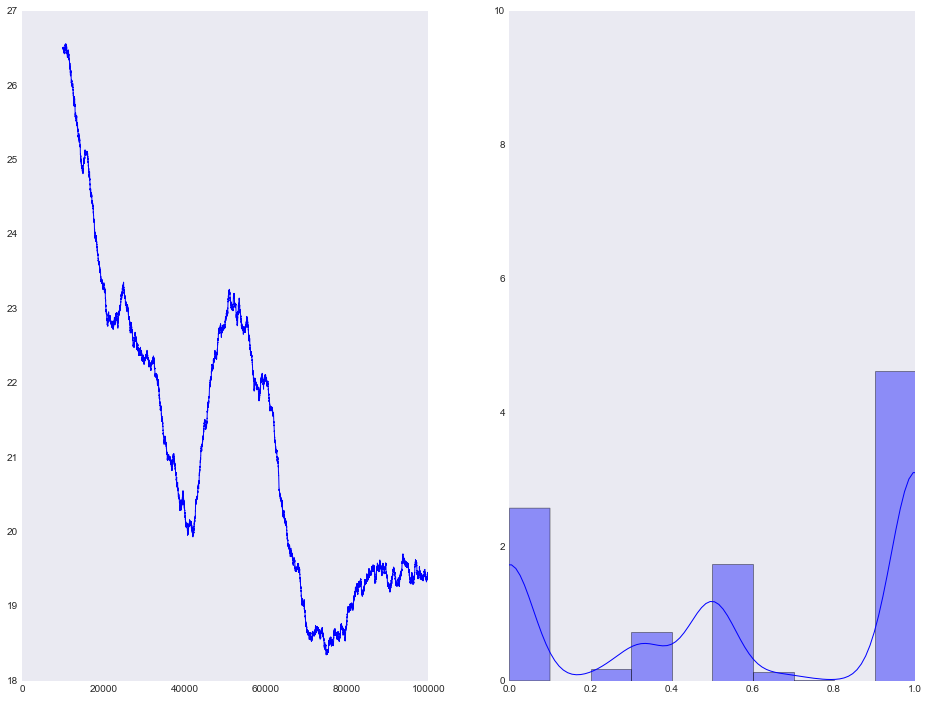

In [8]:
fig, ax =plt.subplots(1,2)
plt.subplot(1, 2, 1)
plt.plot(pd.Series(model_simple._loss[:-25000]).rolling(10000).mean());

plt.subplot(1, 2, 2)
g = sns.distplot(model_simple._jaccard_scores, bins=10, norm_hist=True)
g.set(xlim=(0.0, 1.0), ylim=(0.0,7.0))
fig.show()

In [9]:
print('Mean of the loss function on the last 10k train samples: %0.2f' % np.mean(model_simple._loss[-35000:-25000]))

Mean of the loss function on the last 10k train samples: 19.45


In [10]:
# проверка джаккара - должно выдать 0.25
jaccard_score([0,0,1,0,0,0,1,0,0],[0,1,1,0,0,1,0,0,0])

0.25

In [11]:
np.mean(model_simple._jaccard_scores)

0.58810714238097139

## Задача 5. L2

Ранее выведено
$$\nabla L = x(y_k-\sigma(z_i))$$
$$-\nabla L = x(\sigma(z_i)-y_k)$$
или просто y - sigma в коде

теперь надо добавить к нему $\lambda w_{ki}$, где $\lambda$ задается, а $w_{ki}$ - это вес из вектора весов

In [12]:
class LogRegressorL2():
    
    def __init__(self, tags=top_tags):      
        self._vocab = {}        
        self._w = dict([(t, defaultdict(int)) for t in tags])
        self._b = dict([(t, 0) for t in tags])
        self._tags = set(tags)
        self._jaccard_scores=[]
    
    def iterate_file(self, 
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     tolerance=1e-16,
                     our_lambda=0.01):
        self._loss = []
        n = 0
        with open(fname, 'r') as f:            
            for line in tqdm_notebook(f, total=total, mininterval=1):
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                sentence = sentence.split(' ')
                tags = set(tags.split(' '))
                sample_loss = 0
                tag_probabilities = []
                tag_markings = []
                
                for tag in self._tags:
                    y = int(tag in tags)
                    z = self._b[tag] 
                    for word in sentence:
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        if word not in self._vocab:
                            self._vocab[word] = len(self._vocab)
                        z += self._w[tag][self._vocab[word]] 
                        
                    sigma = 1/(1 + np.exp(-z)) if z >= 0 else 1 - 1/(1 + np.exp(z))
                    sample_loss += -y*np.log(np.max([tolerance, sigma])) if y == 1 else \
                                   -(1 - y)*np.log(1 - np.min([1 - tolerance, sigma]))
                    if n < top_n_train:
                        dLdw = y-sigma 
                        for word in sentence:
                            dL2dw = our_lambda*self._w[tag][self._vocab[word]]
                            self._w[tag][self._vocab[word]] -= learning_rate*(-dLdw + dL2dw)
                            
                        self._b[tag] -= learning_rate*(-dLdw)
                    else:
                        if sigma >= 0.9:
                            tag_probabilities.append(1)
                        else:
                            tag_probabilities.append(0)
                        tag_markings.append(y)
                n += 1
                self._loss.append(sample_loss)
                if n >= top_n_train:
                    self._jaccard_scores.append(jaccard_score(tag_markings, tag_probabilities))

In [13]:
model_L2 = LogRegressorL2()
model_L2.iterate_file()

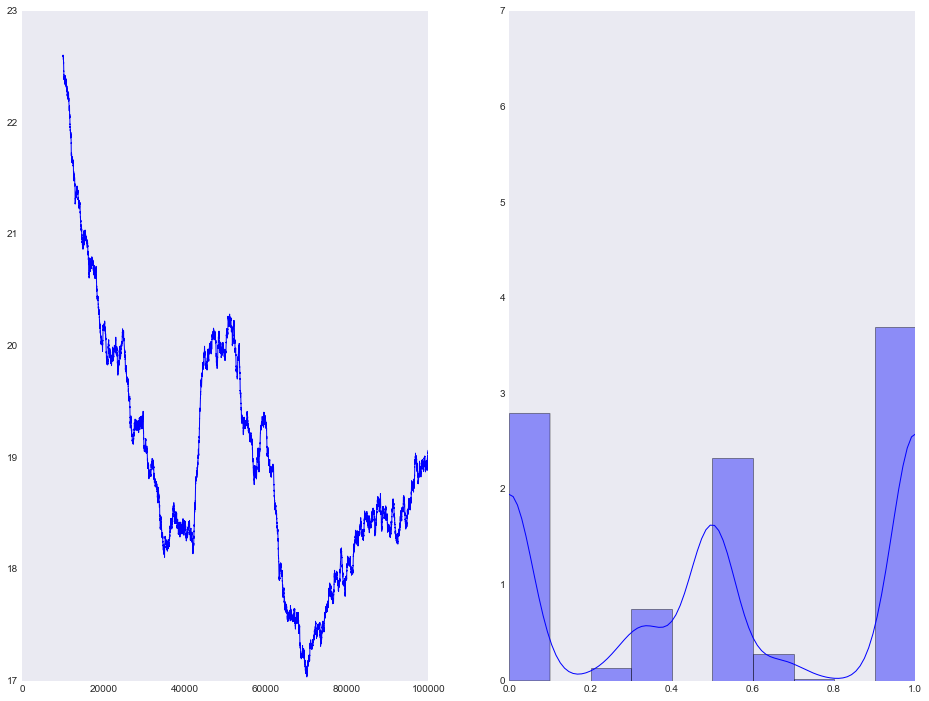

In [14]:
fig, ax =plt.subplots(1,2)
plt.subplot(1, 2, 1)
plt.plot(pd.Series(model_L2._loss[:-25000]).rolling(10000).mean());

plt.subplot(1, 2, 2)
g = sns.distplot(model_L2._jaccard_scores, bins=10, norm_hist=True)
g.set(xlim=(0.0, 1.0), ylim=(0.0,7.0))
fig.show()

In [15]:
np.mean(model_L2._loss[-35000:-25000])

19.053517431264865

In [16]:
np.mean(model_L2._jaccard_scores)

0.53459128301534609

## 6. Формула для L1+L2

$$\lambda [ 2w\gamma + (1-\gamma)sign(w)]$$

## 7. ElasticNet

In [21]:
class LogRegressorElastic():
    
    def __init__(self, tags=top_tags):      
        self._vocab = {}
        self._w = dict([(t, defaultdict(int)) for t in tags])
        self._b = dict([(t, 0) for t in tags])
        self._tags = set(tags)
        self._jaccard_scores=[]
        self.create_vocab()
        
    
    def make_vocab_word_list(self, fname=DS_FILE_NAME, total=100000, remaining=10000):
        hist_dict = {}
        k=0
        with open(fname, 'r') as f:            
            for line in f:
                if k>=total:
                    break
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue
                text = pair[0].split(' ')
                for word in text:
                    if word in hist_dict:
                        hist_dict[word]+=1
                    else:
                        hist_dict[word]=0
                k+=1
        if remaining>0 :
            sorted_hist = sorted(hist_dict.iteritems(), key=lambda x: x[-1], reverse=True)[:remaining]
            return [sorted_hist[x][0] for x in range(len(sorted_hist))]
        else:
            return [x for x in hist_dict]
        
    def create_vocab(self, n=0):
        print('Creating vocabulary')
        word_list = self.make_vocab_word_list(remaining=n)
        self._vocab = {word_list[x]:x for x in range(len(word_list))}
        print('Created vocabulary with {} length'.format(len(self._vocab)))
    
    def filter_vocab(self,n=10000):
        print('Filtering...')
        word_list = self.make_vocab_word_list(remaining=n)
        self._vocab = {a:b for a,b in self._vocab.iteritems() if a in word_list}
        print('Filtered to vocabulary with {} length'.format(len(self._vocab)))
    
    def sign(self,a):
        if a<0:
            return -1
        if a==0:
            return 0
        if a>0:
            return 1
    
    def predict_proba(self, sentence):
        word_list = sentence.split(' ')
        tag_list = []
        for tag in self._tags:
            z = self._b[tag]
            
            for word in sentence:
                if word not in self._vocab:
                    continue
                z += self._w[tag][self._vocab[word]] 
            
            sigma = 1/(1 + np.exp(-z)) if z >= 0 else 1 - 1/(1 + np.exp(z))
            print(tag, sigma)
            if sigma>=0.9:
                tag_list.append(tag)
        return tag_list
    
    def iterate_file(self, 
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     tolerance=1e-16,
                     our_lambda=0.0002,
                     our_gamma=0.1,
                     update_vocab=True):
        self._loss = []
        n = 0
        lambd2gamm = our_lambda*2*our_gamma
        rev_gamm = our_lambda*(1-our_gamma)
        with open(fname, 'r') as f:            
            for line in tqdm_notebook(f, total=total, mininterval=1):
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                sentence = sentence.split(' ')
                tags = set(tags.split(' '))
                sample_loss = 0
                tag_probabilities = []
                tag_markings = []
                
                valued_words = [word for word in sentence if word in self._vocab]
                
                for tag in self._tags:
                    y = int(tag in tags)
                    z = self._b[tag] 
                    
                    for word in valued_words:      
                        z += self._w[tag][self._vocab[word]] 
                        
                    sigma = 1/(1 + np.exp(-z)) if z >= 0 else 1 - 1/(1 + np.exp(z))
                    sample_loss += -y*np.log(np.max([tolerance, sigma])) if y == 1 else \
                                   -(1 - y)*np.log(1 - np.min([1 - tolerance, sigma]))
                        
                    if n < top_n_train:
                        dLdw = y-sigma 
                        for word in valued_words:
                            a = self._w[tag][self._vocab[word]]
                            dEldw = lambd2gamm*a + rev_gamm*self.sign(a)
                            self._w[tag][self._vocab[word]] -= learning_rate*(-dLdw + dEldw)
                            
                        self._b[tag] -= learning_rate*(-dLdw)
                    else:
                        if sigma >= 0.9:
                            tag_probabilities.append(1)
                        else:
                            tag_probabilities.append(0)
                        tag_markings.append(y)
                n += 1
                self._loss.append(sample_loss)
                if n >= top_n_train:
                    self._jaccard_scores.append(jaccard_score(tag_markings, tag_probabilities))

In [22]:
model_elastic = LogRegressorElastic()

Creating vocabulary
Created vocabulary with 519290 length


In [23]:
len(model_elastic._vocab)

519290

In [24]:
model_elastic.iterate_file()

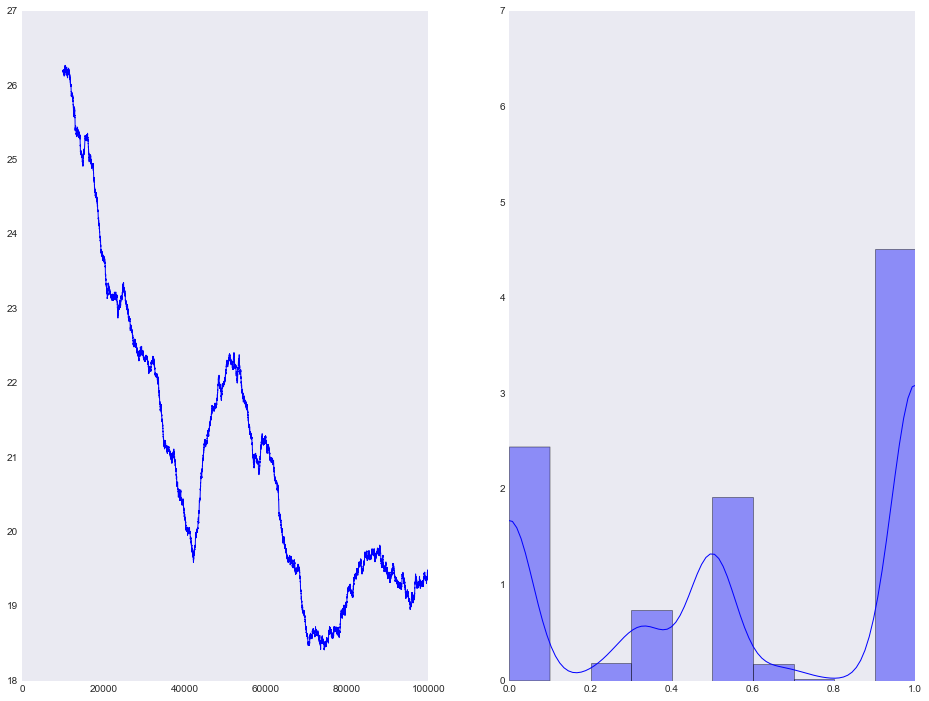

In [25]:
fig, ax =plt.subplots(1,2)
plt.subplot(1, 2, 1)
plt.plot(pd.Series(model_elastic._loss[:-25000]).rolling(10000).mean());

plt.subplot(1, 2, 2)
g = sns.distplot(model_elastic._jaccard_scores, bins=10, norm_hist=True)
g.set(xlim=(0.0, 1.0), ylim=(0.0,7.0))
fig.show()

In [26]:
np.mean(model_elastic._jaccard_scores)

0.5896697465434716

## 8. Самые важные

(чуть ранее здесь всё же не было java)

In [27]:
p = dict(zip(model_elastic._vocab.values(),model_elastic._vocab.keys()))
for tag in top_tags:
    l = [p[x] for x in dict(Counter(model_elastic._w[tag]).most_common(5))]
    print tag, l, tag in l

jquery ['jquery', 'ajax', 'span', 'ready', 'val'] True
java ['servlet', 'java', 'spring', 'println', 'hibernate'] True
python ['py', 'django', 'def', 'python', 'np'] True
javascript ['x20', '125', 'x30', '3', 'javascript'] True
ios ['nsstring', 'nil', 'ios', 'uiview', 'dylib'] True
c++ ['cout', 'c++', 'avrf', 'cpp', 'std'] True
c# ['net', 'binding', 'foreach', 'writeline', 'linq'] False
html ['nbsp', 'amp', 'br', '3', 'html'] True
android ['activity', 'imgsrv', 'art', '29297', 'android'] True
php ['x5c', 'echo', 'php', '125', '_post'] True


## 9 и 10. Сокращение размера словаря, предсказание

In [28]:
model_elastic.filter_vocab()

Filtering...
Filtered to vocabulary with 10000 length


In [29]:
model_elastic.iterate_file(learning_rate = 0.01)

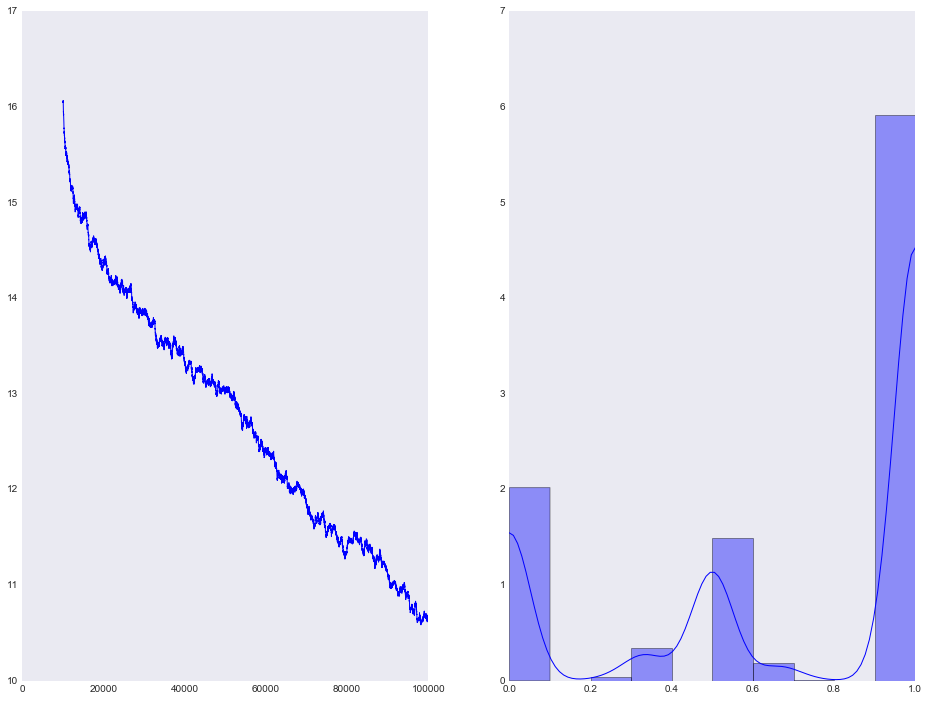

In [30]:
fig, ax =plt.subplots(1,2)
plt.subplot(1, 2, 1)
plt.plot(pd.Series(model_elastic._loss[:-25000]).rolling(10000).mean());

plt.subplot(1, 2, 2)
g = sns.distplot(model_elastic._jaccard_scores[25001:], bins=10, norm_hist=True)
g.set(xlim=(0.0, 1.0), ylim=(0.0,7.0))
fig.show()

In [31]:
np.mean(model_elastic._jaccard_scores[25001:])

0.69152233910643579

In [32]:
sentence = ("I want to improve my coding skills, so I have planned write " +
            "a Mobile Application.need to choose between Apple's iOS or Google's Android." +
            " my background: I have done basic programming in .Net,C/C++,Python and PHP " +
            "in college, so got OOP concepts covered. about my skill level, I just know " +
            "concepts and basic syntax. But can't write complex applications, if asked :(" +
            " So decided to hone my skills, And I wanted to know which is easier to " +
            "learn for a programming n00b. A) iOS which uses Objective C B) Android " + 
            "which uses Java. I want to decide based on difficulty level")


model_elastic.predict_proba(sentence)

('jquery', 0.0)
('java', 0.0)
('python', 0.0)
('javascript', 1.0)
('ios', 0.0)
('c++', 0.0)
('c#', 0.0)
('html', 1.0)
('android', 0.0)
('php', 0.0)


['javascript', 'html']

In [33]:
sentence = ("I want to improve my coding skills so I have planned write " +
            "a Mobile Application need to choose between Apple iOS or Google Android " +
            "my background I have done basic programming in .Net C C++ Python and PHP " +
            "in college so got OOP concepts covered about my skill level, I just know " +
            "concepts and basic syntax But can't write complex applications, if asked " +
            "So decided to hone my skills And I wanted to know which is easier to " +
            "learn for a programming n00b. A iOS which uses Objective C B Android " + 
            "which uses Java I want to decide based on difficulty level").lower()


model_elastic.predict_proba(sentence)

('jquery', 0.0)
('java', 0.0)
('python', 0.0)
('javascript', 1.0)
('ios', 0.0)
('c++', 0.0)
('c#', 0.0)
('html', 1.0)
('android', 0.0)
('php', 0.0)


['javascript', 'html']

## ИТОГ

In [44]:
import matplotlib.lines as lines
def add_line(ax, model, n_from=0, n_to=25000):
    pr = np.mean(model._jaccard_scores[n_from:n_to])*10.0
    line = [(0,pr), (1,pr)]
    (line_xs,line_ys) = zip(*line)
    ax.add_line(lines.Line2D(line_xs,line_ys, color='red', linewidth=2)) 

5.88120666667
5.34586
5.89669746543
6.91522339106


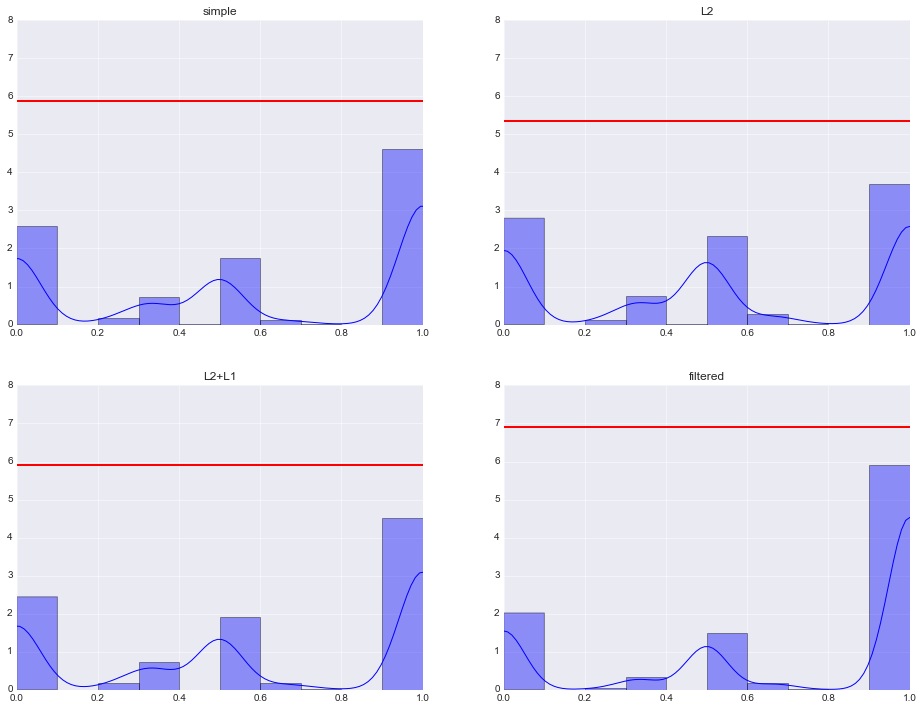

In [46]:
fig, ax = plt.subplots(nrows=2,ncols=2)
for x in range(2):
    for y in range(2):
        ax[x][y].set_ylim(0,8)
        ax[x][y].set_xlim(0,1)
        ax[x][y].grid(True)

sns.distplot(model_simple._jaccard_scores, bins=10, norm_hist=False, ax=ax[0][0]).set_title('simple')
add_line(ax[0][0], model_simple)

sns.distplot(model_L2._jaccard_scores, bins=10, norm_hist=False, ax=ax[0][1]).set_title('L2')
add_line(ax[0][1], model_L2)

sns.distplot(model_elastic._jaccard_scores[:25001], bins=10, norm_hist=False, ax=ax[1][0]).set_title('L2+L1')
add_line(ax[1][0], model_elastic, n_to=25001)

sns.distplot(model_elastic._jaccard_scores[25001:], bins=10, norm_hist=False, ax=ax[1][1]).set_title('filtered')
add_line(ax[1][1], model_elastic, n_from=25001, n_to=50002)

fig.show()